# Palm vein recognition


Ici, vous allez trouver une démonstration d'un modèle pré-entraîné de notre datasets de veines palmaires. 

Ce projet a été développé par : Kenan GONNOT, Lorenzo MARQUES et Fayçal MERZOUK.  

**L’objectif** est de créer un modèle de veines verification : «Est-ce la bonne personne ? »

Vous pouvez retrouver ce code sur [GitHub](https://github.com/kenanGonnot/cnn_palmar_veins). 



## Table of Contents

- [1 - Imports](#1)
- [2 - Load images - Train(70%) Test(15%) Val(15%)](#2)
- [3 - Creation of the model - ResNet50 with Transfer Learning](#3)
- [4 - Plot](#4)

## Imports

In [1]:
import gc
import glob
import os
import sys
import cv2
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from random import randrange
from tqdm import tqdm, tnrange
from tqdm.notebook import tqdm_notebook

import warnings

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split

from keras.optimizer_v2.gradient_descent import SGD
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Dense, MaxPooling2D, Flatten, Conv2D, Lambda, Dropout, LeakyReLU, BatchNormalization, Activation, AveragePooling2D, GlobalAveragePooling2D
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator

from mlxtend.evaluate import accuracy

from tensorflow.keras.optimizers import Adam,RMSprop,SGD, Nadam
#from tensorflow.keras.utils import to_categorical
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding

In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # ignore tensorflow warnings
warnings.filterwarnings("ignore")

## Load images - Train(70%) Test(15%) Val(15%)

In [3]:
path_data = "data/data_palm_vein/NIR"
architecture_path = "app/deployed_model/XceptionWithoutTL.json"
weight_path="app/deployed_model/XceptionWithoutTL.h5"

In [4]:
def load_img(path, xdim=128, ydim=128, nb_of_users = 500):
    label_names = []
    X = []
    y = []
    nb_of_users = nb_of_users - 1
    count = 0
    identity = -1
    directories = os.listdir(path)
    directories.sort()
    for dirname in tqdm_notebook(directories, desc="Loading images..."):
        if dirname == ".DS_Store": continue
        label_names.append(dirname)
        data_path = os.path.join(path + "/" + dirname, '*g')
        files = glob.glob(data_path)
        if identity >= nb_of_users: break
        identity += 1
        files.sort()
        for f1 in files:
            img = cv2.imread(f1, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img,(int(xdim*1), int(ydim*1)))
            X.append(np.array(img))
            y.append(identity)
            count += 1
    X = np.array(X)
    y = np.array(y)
    print("\n ================= Summary of extraction ================= \n")
    print(count, ' images lues')
    print("\nX.shape = ", X.shape)
    print("y.shape = ", y.shape)
    gc.collect()
    return X, y, label_names

In [5]:
X, y, label_names = load_img(path_data, nb_of_users=500)

Loading images...:   0%|          | 0/501 [00:00<?, ?it/s]


 ================= Summary of extraction ================= 

6000  images lues

X.shape =  (6000, 128, 128)
y.shape =  (6000,)


In [6]:
X = X / 255.
X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)
y = to_categorical(y)

print("\nPREPROCESSING DATA")
print("-----------------------------------------")
print("\nX shape : {}".format(X.shape))
print("-----------------------------------------")
print("y shape : {}\n".format(y.shape))
print("\n\n-----------------------------------------")
print("Il y a {} utilisateur(s) dans le dataset prélevé.".format(y.shape[1]))


PREPROCESSING DATA
-----------------------------------------

X shape : (6000, 128, 128, 1)
-----------------------------------------
y shape : (6000, 500)



-----------------------------------------
Il y a 500 utilisateur(s) dans le dataset prélevé.


In [7]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
print("\nSplitting data ...\n")
print("\n=============================== Splitting data =============================== \n\n")
print("X_train shape   : {:19}    |    y_train shape : {}\n".format(str(X_train.shape), y_train.shape))
print("------------------------------------------------------------------------------")
print("X_val shape     : {:19}    |    y_val shape   : {}\n".format(str(X_val.shape), y_val.shape))
print("------------------------------------------------------------------------------")
print("X_test shape    : {:19}    |    y_test shape  : {}\n".format(str(X_test.shape), y_test.shape))


Splitting data ...


=============================== Splitting data =============================== 


X_train shape   : (4200, 128, 128, 1)    |    y_train shape : (4200, 500)

------------------------------------------------------------------------------
X_val shape     : (900, 128, 128, 1)     |    y_val shape   : (900, 500)

------------------------------------------------------------------------------
X_test shape    : (900, 128, 128, 1)     |    y_test shape  : (900, 500)



## Loads the model - pretrained 

In [13]:
from keras.models import model_from_json

json_file = open(architecture_path, 'r')
loaded_model_json = json_file.read()
json_file.close()

model = model_from_json(loaded_model_json)
model.load_weights(weight_path)
model.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])
print("------------------------------ Model loaded ------------------------------")
print(model.summary())

------------------------------ Model loaded ------------------------------
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 4, 4, 2048)        20860904  
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              33555456  
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_______________________________________________

In [14]:
Nombre_classes = y.shape[1]
input_shape = (X.shape[1], X.shape[2], 1)
print("\nNombres de classes : {}   |   Input shape : {}\n".format(Nombre_classes, input_shape))


Nombres de classes : 500   |   Input shape : (128, 128, 1)



### Evaluation of the model pretrained

In [16]:
val = model.evaluate(X_temp, y_temp)

print("\n ================= Evaluation : Resnet 50 model ================= \n")
print("  Results : \n")
print("Loss  : %.2f" % (val[0]))
print("Score : %.2f%%" % (val[1] * 100))

57/57 [==============================] - 8s 146ms/step - loss: 0.0296 - accuracy: 0.9950

 ================= Evaluation : Resnet 50 model ================= 

  Results : 

Loss  : 0.03
Score : 99.50%


## Plot images with prediction 

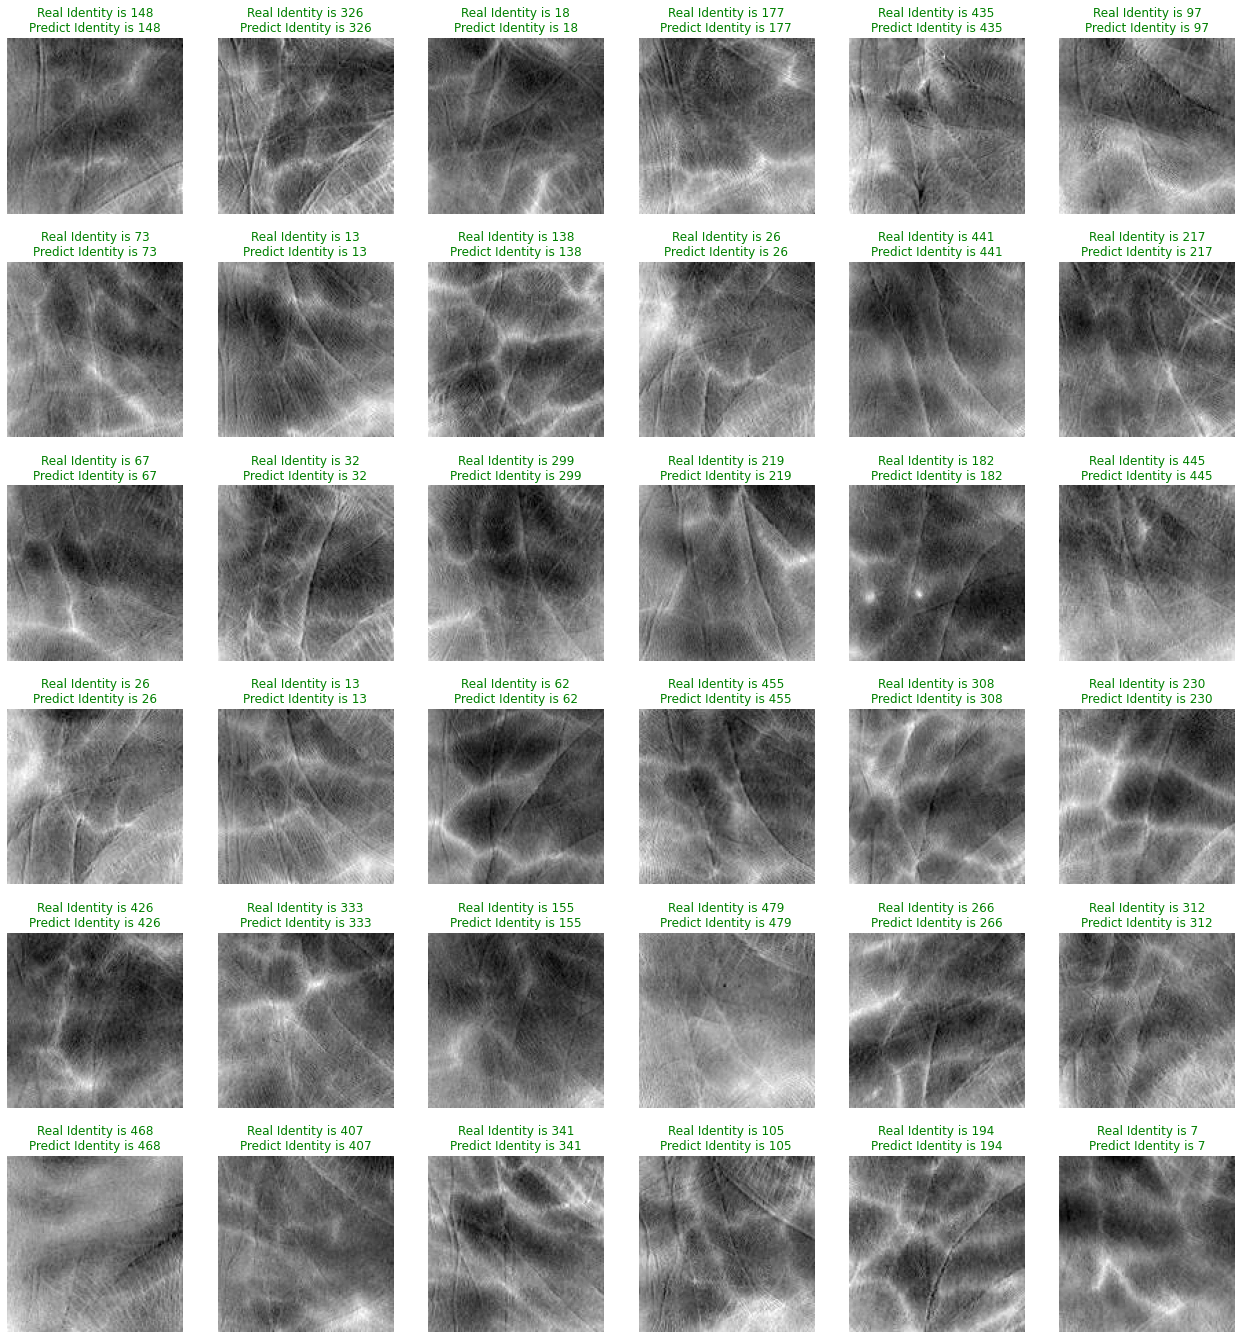

In [18]:
plt.figure(figsize=(22, 24))
y_pred = model.predict(X_temp)

for i in range(36):
    ax = plt.subplot(6, 6, i + 1)
    plt.imshow(X_temp[i], cmap=plt.cm.binary)
    title_obj = plt.title("Real Identity is {}\nPredict Identity is {}".format(np.argmax(y_temp[i]), y_pred[i].argmax()))
    if np.argmax(y_pred[i]) == np.argmax(y_temp[i]):
        plt.setp(title_obj, color='green')
    else:
        plt.setp(title_obj, color='red')    
    plt.axis("off")